# Word Lists and Sentiment Analysis


A traditional method of analyzing texts involes computing the proportion of words with positive connotations, the proportion of words with negative connotations, and the proportion of words that are neutral. This method is commonly referred to as *sentiment analysis*. The typical approach to sentiment analysis is to see how many words within a given text are also contained within a predefined list of words associated with a sentiment. So, the text "I am having a bad day" might score a "1" on a negative sentiment scale because it contains one negative word, "bad," or it might score a ".17" because one of six words in the text is negative. Some sentiment systems rank words on a scale, so that "terrific" might be a 5 while "fine" scores a 1. 

Some systems go beyond positive and negative. The proprietary LIWC program, for example, extends this to measure dozens of other word attributes, such as "tone", "analytic thinking", and "clout." More generally, these methods can be used whenever you have a list of words, and you want to count their occurrences in a set of texts. They are commonly referred to as "dictionary methods."

This lesson introduces two different dictionaries that are available in Python, AFINN and Vader. It concludes by showing how to analyze a text corpus for occurrences of words contained in any arbitrary word list.

This lesson assumes your computer has an Anaconda Python 3.7 distribution installed.

# AFINN

[AFINN](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) is an English word list developed by Finn Årup Nielsen. Words scores range from minus five (negative sentiment) to plus five (positive sentiment). The English language dictionary consists of 2,477 coded words.

If this is your first time running this notebook, you may need to install it:


In [1]:
%pip install afinn

Note: you may need to restart the kernel to use updated packages.


We'll also need to install `matplotlib`for the exercises in this chapter. Don't forget to import `Afinn` and `pandas` as well. Finally, setting the maximum column width in `pandas` to 100 characters will dataframes that are more user-friendly than if we left the column width maximum at 50.  

In [2]:
%matplotlib inline

from afinn import Afinn

import pandas as pd
pd.set_option('max_colwidth', 100)

After importing `Afinn`, you need to set the language. Available languages include English (`en`), Danish (`da`), Swedish (`sv`),  Norwegian (`no`), french (`fr`), or emoticon (`emoticons`). 

For our purposes we'll set the language to English.

In [3]:
afinn = Afinn(language='en')

The `score` method returns the sum of word valence scores for a text string. We can look at the score for a number of phrases we know intuitively to carry positive or negative sentiment:

In [4]:
afinn.score('Bad day.')

-3.0

In [5]:
afinn.score('Good day.')

3.0

In [6]:
afinn.score('Horrible, bad day.')

-6.0

In [7]:
afinn.score('Excellent, good day.')

6.0

In [ ]:
afinn_no = Afinn(language='no')


In [13]:
afinn_no.score('Google translate er min beste venn!')

4.0

Conveniently, `afinn` preprocesses text strings by removing the punctuation and converting all the words to lower case before analyzing it. 

### AFINN Exercise 1
Create a sentence with a score of +10 or greater and one of -10 or lower.


## Behind the scenes

 Before using a sentiment dictionary, it is useful to see whether it has any face validity.  To do that, we can look at a sample of the words from the list.

Since we've imported `pandas`, the cell below will load the  word list from the tab-delimited version on Afinn's GitHub page as a pandas dataframe and display a sample of 10 words.

In [8]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pd.read_csv(afinn_wl_url, 
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names

seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


We can get a sense of the distribution of word values by plotting them:

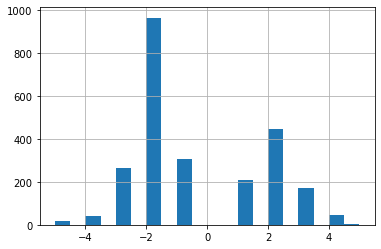

In [9]:
%matplotlib inline

afinn_wl_df['value'].hist(bins=20)

Overall, the dictionary appears to have more negative words than positive words, but the values for both positive and negative words are rarely too extreme, with 2 and -2 as the two most common values.

## Applying the dictionary

We can use Afinn to analyze more extensive text databases as well. To demonstrate, we'll walk through how to use Afinn to analyze comments posted on New York Times articles over the month of April 2017. 

*Aashita Kesarwani, [corpus](https://www.kaggle.com/aashita/nyt-comments/home)*

In [10]:
nyt_comments = pd.read_csv('CommentsApril2017.csv', low_memory = False)

We can use the `head` method to get a sense of the dataframe.

In [11]:
nyt_comments.head()

,Unnamed: 0,commentBody,commentSequence,commentType,editorsSelection,userLocation,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial
0,39843,Purple is NOT a feminine color. I've always loved a deep blue purple. I now wear it in honor of ...,22204231,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,OpEd,819.0,25,Op-Ed
1,42222,Great comment!,22156682,userReply,False,Tucson,Unknown,National,1433.0,1,News
2,119624,"Then how come the 50,000 illegal Irish aren't picking vegetables (number found elsewhere here), ...",22104623,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,National,1249.0,16,News
3,18606,"Psychiatrists are not scientists - they do not follow the scientific method, and certainly not t...",22180867,comment,False,montreal,Unknown,National,1081.0,0,News
4,4570,We've been having this same conversation for decades.<br/>The Democrats are Charlie Brown and th...,22291060,comment,False,Brooklyn,Politics,National,1134.0,1,News


With Afinn, the primary column of interest is *commentBody.* 

To estimate the Afinn sentiment score for all of the responses in the dataframe, we can `apply` the scorer to the commentBody column to create a new column. Applying this function takes a couple of seconds.

In [12]:
nyt_comments['afinn_score'] = nyt_comments['commentBody'].apply(afinn.score)

`describe` gives a sense of the distribution. 

In [13]:
nyt_comments['afinn_score'].describe()

count    49000.000000
mean        -0.212082
std          6.957044
min        -67.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max         48.000000
Name: afinn_score, dtype: float64

It is also useful to sort by `afinn_score` to get a sense of what is in the extreme scoring comments. In this case, I subset the dataframe to display just the two relevant columns. 

In [14]:
columns_to_display = ['commentBody', 'afinn_score']

nyt_comments.sort_values(by='afinn_score')[columns_to_display].head(10)

,commentBody,afinn_score
28668,Dozens of Police Injured in G20 Protests as Merkel Seeks Consensus<br/>By Reuters<br/><br/>This ...,-67.0
876,"It might be helpful, to put the issue into some sort of perspective,<br/>if we look back at the ...",-65.0
31821,Said to be brought to tears upon learning about the daily plight and maltreatment of babies and ...,-65.0
12443,"<a href=""http://www.cbsnews.com/news/death-penalty-deters-murders-studies-say/"" title=""http://ww...",-60.0
33015,I grow tired of hearing that both parties have been equally guilty of not responding to the angs...,-57.0
1340,"""Le Pen’s party, whose racist ideology was once taboo, has joined the mainstream.""<br/><br/>Le P...",-56.0
18153,"The Trump presidency is a tale told by an idiot, full of sound and fury, signifying nothing. E...",-55.0
13098,I agree with everything said here. <br/><br/>All I want to add is that it's hard to read this ti...,-54.0
28792,Would you describe (former prime minister of Israel) Menachem Begin as a terrorist? <br/><br/>He...,-54.0
32966,"""In the 1990s, North Korea continued with its nuclear program even as a famine claimed the lives...",-52.0


In [15]:
worst = nyt_comments.sort_values(by='afinn_score').index[0]

print(nyt_comments.iloc[worst]['commentBody'])


Dozens of Police Injured in G20 Protests as Merkel Seeks Consensus<br/>By Reuters<br/><br/>This article really caught my eye because when i read it i thought that the violent protesters are what a lot of media will cover. They will focus on the violence and the crimes that they will not cover the reason for the protests or the people that are actually trying to peacefully protest. Before I started reading about the G20 protests on the New York Times all I saw was a group of violent masked people destroying cars and looting stores. This is how I assume a lot of people have and will continue to view them.<br/>It is terrible when protests turn violent just as they did here. They should not hurt police officers when they are protesting. It is ridiculous. It is just not the right way to protest . The thing that violent protest does is shed negative light on the protesters and political parties can use these examples when they are saying that their opposing parties are just violent people. I

By default, the sort is ascending, mean the lowest scoring, or most negative comments, are displayed by `head`. The comments with the highest score are shown with `tail`. 

In [16]:
nyt_comments.sort_values(by='afinn_score')[columns_to_display].tail(10)

,commentBody,afinn_score
20575,His lawyers are grasping at straws.... In the history of art I'm willing to bet one cannot find ...,38.0
13939,"My goodness... This hit home for me in so many ways. I was (am) a Tomboy, who has grown into a s...",39.0
5547,"I think the new production is a vast improvement over the 1969 one, which was well overdue for r...",40.0
1536,The Republican Party primarily stands for the massive redistribution of wealth from everyone to ...,41.0
5310,"The Princess power,<br/>to go back to a time of innocence<br/>to strong female characters<br/>al...",42.0
21305,"In addition, gentle readers, let me suggest that while IQ is important, it isn't necessarily des...",42.0
10639,"""Driven | 2017 Porsche 911 Turbo S""<br/><br/> Since I was born my Favorite thing to do is watch...",42.0
23200,"While scrolling through the many articles, ""The Triumph of 'Wonder Woman'"" caught my eye. Wonder...",43.0
3508,I may not always agree with the decisions made by the supreme court but up until now I've always...,46.0
15769,"Family wealth is the most important determinate of all types of success. Over the last 20 years,...",48.0


In [28]:
best = nyt_comments.sort_values(by='afinn_score', ascending=False).index[0]

print(nyt_comments.iloc[best]['commentBody'])



In my town, we used to go looking for a field so my son and I could have a catch on a real field.  Often we found other fathers and sons already there.   The only fun that was rare, was the pickup game (we did see that occur but not as often as the sandlots of many years ago).   But the simple pleasure of catch is alive and well.<br/><br/>But joy of catch with Dad, for a rare kid obsessed with the game, would naturally lead for a desire for more as the kid grows.  The fun just morphs from joy of fresh air and family time, to joy of accomplishment.   A few lessons to enable the next level of enjoyment is how I looked at it.    There is lots of sorrow in the game, mostly coaches who care more about winning and playing their favorites.   But the joy of catch with Dad, can for some kids become joy of team, joy of results from progress.   Happy to say that after more than a decade of baseball, my son is very happily part of a college team, a dream he has worked towards.  He enjoys the camra

One of the drawbacks to using the raw Afinn score is the that longer texts may yield higher values simply because they contain more words. To adjust for that, we can divide the score by the number of words in the text. 

The most straightforward way to count words in a Python string is to use the `split` method, which splits a string based on white spaces, and then count the length of the resulting list.

In [17]:
from pdtext.tf import word_count

In [18]:
word_count('This sentence has seven words in it.')

7

You can employ that function on our dataframe to create a new column, `word_count` using `appply` to the text column, `commentBody`.

In [19]:
nyt_comments['word_count'] = nyt_comments['commentBody'].apply(word_count)

In [20]:
nyt_comments['word_count'].describe()

count    49000.000000
mean        70.660449
std         61.628161
min          1.000000
25%         24.000000
50%         51.000000
75%         97.000000
max        295.000000
Name: word_count, dtype: float64

We can divide the original score by the word count to produce `afinn_adjusted`. This isn't exactly a percentage variable, since word scores in Afinn can range from -5 to 5, but it is a useful adjustment to control for variable comment length. To make it clearer that this isn't a percent score, and to make the results more readable, the adjustment is multiplied by 100.

In [21]:
nyt_comments['afinn_adjusted'] = nyt_comments['afinn_score'] / nyt_comments['word_count'] * 100

In [22]:
nyt_comments['afinn_adjusted'].describe()

count    49000.000000
mean         0.439222
std         17.437913
min       -300.000000
25%         -5.882353
50%          0.000000
75%          5.929691
max        500.000000
Name: afinn_adjusted, dtype: float64

You can use `groupby` to see how the sentiment score varies by key characteristics.

In [23]:
nyt_comments.groupby('editorsSelection')[['afinn_adjusted','afinn_score']].describe()

afinn_adjusted                                             \
                          count      mean        std         min       25%   
editorsSelection                                                             
False                   47874.0  0.458633  17.560210 -300.000000 -5.920079   
True                     1126.0 -0.386079  11.023481 -133.333333 -5.714286   

                                            afinn_score                      \
                  50%       75%         max       count      mean       std   
editorsSelection                                                              
False             0.0  5.970149  500.000000     47874.0 -0.204161  6.895753   
True              0.0  5.068393   85.714286      1126.0 -0.548845  9.190082   

                                             
                   min  25%  50%  75%   max  
editorsSelection                             
False            -67.0 -3.0  0.0  3.0  48.0  
True             -38.0 -5.0  0.0  4.0  39.0

Since the syntax in the command line above may be difficult to decipher, some descriptions are provided below.


- **nyt_comments**: The dataframe we want to use.


- **.groupby('editorsSelection')**: This creates a pandas `groupby` object split by `rating` values.


- **['afinn_adjusted','afinn_score']**: These are the specific column wes want to focus on.


- **.describe( )**: This produces descriptive statistics for each of the groups.


Pandas can also be used to create the absolute value of a variable using the `abs` method. This is useful for exploring to what extent, in this case, editors embrace or avoid comments that are extreme, either positive or negative.

In [52]:
nyt_comments['abs_afinn_adjusted'] = nyt_comments['afinn_adjusted'].abs()

In [50]:
nyt_comments['abs_afinn_score'] = nyt_comments['afinn_score'].abs()

In [53]:
nyt_comments.groupby('editorsSelection')[['abs_afinn_adjusted','abs_afinn_score']].describe()

abs_afinn_adjusted                                      \
                              count      mean        std  min       25%   
editorsSelection                                                          
False                       47874.0  9.570725  14.729923  0.0  2.173913   
True                         1126.0  7.326648   8.242502  0.0  2.325581   

                                             abs_afinn_score            \
                       50%   75%         max           count      mean   
editorsSelection                                                         
False             5.952381  12.0  500.000000         47874.0  4.572586   
True              5.405405  10.0  133.333333          1126.0  6.664298   

                                                      
                       std  min  25%  50%  75%   max  
editorsSelection                                      
False             5.165666  0.0  1.0  3.0  6.0  67.0  
True              6.348760  0.0  2.0  5.0  9.0  39.0

### AFINN Exercise 2

Make a histogram of the sentiment of UN general election speeches


In [ ]:
# load the data

# Apply afinn.score to text column

# Histogram feature

#### Vader

A second method for sentiment analysis is [vader](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner). According to the authors, it is, "a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." 

As with Afinn, Vader measures both the strength and direction of sentiment. Based on the work of 10 coders, the Vader dictionary includes approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang. 

Unlike Afinn, Vader scores an entire text, not just words. Looking at the whole text allows for the algorithm to adjust for negations, such as "not", booster words, such as "remarkably". It also scores words written in all caps as more intense. Vader returns the proportion of a text that is negative, positive, and neutral, along with a combined score. 

There is a version included with nltk (`from nltk.sentiment.vader import SentimentIntensityAnalyzer`) but a more recent version can be separately installed:



In [ ]:
%pip install vaderSentiment

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Vader requires that you set up an analyzer.

In [25]:
analyzer = SentimentIntensityAnalyzer()

The `polarity_scores` method returns a dictionary with four items. 
- **pos**, **neu**, and **neg**: These are the proportions of text that fall into positive, neutral, and negative categories.


- **compound**: This is the normalized, weighted composite sentiment score for a text. 

In [26]:
analyzer.polarity_scores('Horrible bad day.')

{'neg': 0.875, 'neu': 0.125, 'pos': 0.0, 'compound': -0.7906}

One useful feature of Vader is that it is able to look at works in context and score appropriately. 

In [27]:
analyzer.polarity_scores("At least it isn't a horrible book.")

{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.431}

It also scores contemporary lingo and emojis.

In [28]:
analyzer.polarity_scores('Today SUX!')

{'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}

In [29]:
analyzer.polarity_scores('💋')

{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

### Vader Exercise 1

Rerun the positive and negative sentences you created earlier. How do they score now?


unlike AFINN, which returns a single value, Vader returns a dictionary. This makes it is slightly more complicated to use on an entire pandas dataframe. With this in mind, we'll walk through how we can look at a pandas dataframe using Vader.

First, apply the analyzer on the text column. 

In [30]:
sentiment = nyt_comments['commentBody'].apply(analyzer.polarity_scores)

Our new object `sentiment` is a series, where each item is a dictionary. This series can be unpacked into a dataframe.

In [31]:
sentiment

0         {'neg': 0.137, 'neu': 0.632, 'pos': 0.231, 'compound': 0.6705}
1           {'neg': 0.0, 'neu': 0.185, 'pos': 0.815, 'compound': 0.6588}
2          {'neg': 0.243, 'neu': 0.757, 'pos': 0.0, 'compound': -0.5889}
3        {'neg': 0.121, 'neu': 0.839, 'pos': 0.039, 'compound': -0.8248}
4         {'neg': 0.039, 'neu': 0.839, 'pos': 0.122, 'compound': 0.9429}
                                      ...                               
48995              {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
48996    {'neg': 0.202, 'neu': 0.724, 'pos': 0.074, 'compound': -0.9857}
48997    {'neg': 0.088, 'neu': 0.829, 'pos': 0.083, 'compound': -0.3926}
48998       {'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.5719}
48999      {'neg': 0.235, 'neu': 0.765, 'pos': 0.0, 'compound': -0.9652}
Name: commentBody, Length: 49000, dtype: object

In [32]:
sentiment_df = pd.DataFrame(sentiment.tolist())

sentiment_df.head()

,neg,neu,pos,compound
0,0.137,0.632,0.231,0.6705
1,0.000,0.185,0.815,0.6588
2,0.243,0.757,0.000,-0.5889
3,0.121,0.839,0.039,-0.8248
4,0.039,0.839,0.122,0.9429


The new sentiment dataframe can be merged with the original dataframe.

In [33]:
nyt_comments_sentiment = pd.concat([nyt_comments,sentiment_df], axis = 1)

In [34]:
nyt_comments_sentiment.head()

,Unnamed: 0,commentBody,commentSequence,commentType,editorsSelection,userLocation,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial,afinn_score,word_count,afinn_adjusted,neg,neu,pos,compound
0,39843,Purple is NOT a feminine color. I've always loved a deep blue purple. I now wear it in honor of ...,22204231,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,OpEd,819.0,25,Op-Ed,4.0,43,9.302326,0.137,0.632,0.231,0.6705
1,42222,Great comment!,22156682,userReply,False,Tucson,Unknown,National,1433.0,1,News,3.0,2,150.000000,0.000,0.185,0.815,0.6588
2,119624,"Then how come the 50,000 illegal Irish aren't picking vegetables (number found elsewhere here), ...",22104623,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,National,1249.0,16,News,-3.0,17,-17.647059,0.243,0.757,0.000,-0.5889
3,18606,"Psychiatrists are not scientists - they do not follow the scientific method, and certainly not t...",22180867,comment,False,montreal,Unknown,National,1081.0,0,News,-8.0,106,-7.547170,0.121,0.839,0.039,-0.8248
4,4570,We've been having this same conversation for decades.<br/>The Democrats are Charlie Brown and th...,22291060,comment,False,Brooklyn,Politics,National,1134.0,1,News,1.0,164,0.609756,0.039,0.839,0.122,0.9429


If you intend to do this more than once, it can be useful to *wrap* the entire process into a single function that 1) takes a dataframe, and 2) returns the datframe with the polarity columns appended. To clarify where the sentiment information comes from, the prefix `vader_` is added to each of the polarity scores.

In [54]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield. 
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [55]:
df_vaderized = vaderize(nyt_comments, 'commentBody')

Estimating polarity scores for 49000 cases.


In [56]:
df_vaderized.head()

,Unnamed: 0,commentBody,commentSequence,commentType,editorsSelection,userLocation,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial,afinn_score,word_count,afinn_adjusted,abs_afinn_score,abs_afinn_adjusted,vader_neg,vader_neu,vader_pos,vader_compound
0,39843,Purple is NOT a feminine color. I've always loved a deep blue purple. I now wear it in honor of ...,22204231,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,OpEd,819.0,25,Op-Ed,4.0,43,9.302326,4.0,9.302326,0.137,0.632,0.231,0.6705
1,42222,Great comment!,22156682,userReply,False,Tucson,Unknown,National,1433.0,1,News,3.0,2,150.000000,3.0,150.000000,0.000,0.185,0.815,0.6588
2,119624,"Then how come the 50,000 illegal Irish aren't picking vegetables (number found elsewhere here), ...",22104623,userReply,False,MA. RESISTANCE IS NOT FUTILE,Unknown,National,1249.0,16,News,-3.0,17,-17.647059,3.0,17.647059,0.243,0.757,0.000,-0.5889
3,18606,"Psychiatrists are not scientists - they do not follow the scientific method, and certainly not t...",22180867,comment,False,montreal,Unknown,National,1081.0,0,News,-8.0,106,-7.547170,8.0,7.547170,0.121,0.839,0.039,-0.8248
4,4570,We've been having this same conversation for decades.<br/>The Democrats are Charlie Brown and th...,22291060,comment,False,Brooklyn,Politics,National,1134.0,1,News,1.0,164,0.609756,1.0,0.609756,0.039,0.839,0.122,0.9429


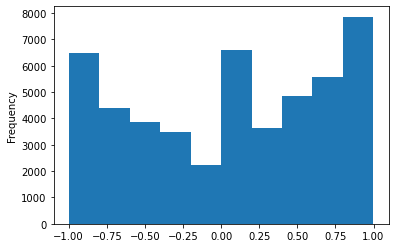

In [57]:
df_vaderized['vader_compound'].plot(kind='hist')

In [58]:
sentiment_variables = ['afinn_adjusted', 'vader_neg', 'vader_neu', 'vader_pos']

df_vaderized.groupby('editorsSelection')[sentiment_variables].mean()

,afinn_adjusted,vader_neg,vader_neu,vader_pos
editorsSelection,,,,
False,0.458633,0.094343,0.79529,0.110364
True,-0.386079,0.099682,0.79524,0.105070


#### Word List

Occasionally, you'll want to use a sentiment list from a different source. More generally, you'll have a word list about any subject, not just attitudes, and you'll want to count the frequency with which those words occur in a collection of texts. Examples of other subjects you might want to look at include words associated with politics or hypothesis testing. 

The final section of this chapter goes through the steps necessary to build a function analyzing texts for the presence of words on *any* given list. In this case, the sample list will be words associated with men that were assembled by [Danielle Sucher](https://github.com/DanielleSucher/Jailbreak-the-Patriarchy). 

The list is stored as a csv file. Pandas can be used to read the word list and turn it into a Python list.

In [40]:

male_csv_location = 'https://raw.githubusercontent.com/nealcaren/KULeuvenBigData/master/notebooks/data/male_words.csv'


male_words_df = pd.read_csv(male_csv_location)

male_words_df.sample(10)

,term
28,fathers
25,dads
9,waiter
42,mr
13,himself
43,father
22,boyfriend
3,gentlemen
33,dude
6,groom


In [41]:
male_words_list = male_words_df['term'].values

The function that looks for cooccurences has two parts. A preliminary helper function transforms the original text string into a list of lower case words stripping out any punctuation. 

In [42]:
def text_to_words(text):
    '''Transform a string to a list of words,
    removing all punctuation.'''
    text = text.lower()

    p = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = ''.join([ch for ch in text if ch not in p])

    return text.split()

In [43]:
text_to_words('Make this lower case and remove! All? Punctuation.')

['make', 'this', 'lower', 'case', 'and', 'remove', 'all', 'punctuation']

The main function takes two arguments, the text and the word list. First, the text string is transformed to a list using `text_to_words`. Second, a new list `intersection` is created which contains only those elements from the text list that are in the word list. Finally, the function returns the length of the intersection. 

In [44]:
def count_occurences(text, word_list):
    '''Count occurences of words from a list in a text string.'''
    text_list = text_to_words(text)

    intersection = [w for w in text_list if w in word_list]

    return len(intersection)

In [45]:
count_occurences('He went to the store.', male_words_list)

1

The function can now be applied on the Times dataframe to count ocurrences of male words in the comments. Since the function takes a second arguement, the word list, this is passed to the `apply` method as a tuple.

In [ ]:
un_df['male_words'] = un_df['text'].apply(count_occurences, 
                                                   args=(male_words_list, ))